# Recipe classification

Imagine a colaborative recipe website chich want to propose an automatic tag function which categorize a proposed recipe among a set of recipe type like french, mexican, italian, korean, .... This functionality will be build thanks to a classifier wich will take as input the ingredients of the recipe and will output the recipe type.

In this exercice we will build such a classifier using a set of labelled recipes.

In [2]:
import pandas as pd
import numpy as np
import json

## Data preprocessing

First we need to read and encode the dataset for further processing. The "recipe_train.json" contains an array of recipe with a cuisine filed with the recipe cuisine type (a string) and an ingredients fileds with an array of ingredients (strings). We first load the data and build an np.array of cuisine type to predict (y) and a list of recipes ingredients. 

In [3]:
with open("./recipes_train.json") as f:
    data_train=json.load(f)
    y = np.array([recipe["cuisine"] for recipe in data_train])
    xtext = [recipe["ingredients"] for recipe in data_train]

We must encode the ingredients and define the numeric features that will describe our recipes. To do so we will take a classic approach in text processing called bag of words so in our case bag of ingredients. Each recipe will be then associated with a big vectors of zeros and one. Each element of this vector will correspond to an ingredients and we will put a one if the recipe use this ingredients and a zero if it's not the case.

To do so we start by computing the list of all the ingredients and a dict which associated to each ingredients an integer

In [4]:
ingredients = np.unique(np.concatenate(xtext))
dict_ingredients = dict((ingredients[i],i) for i in range(0, len(ingredients)))

We may then encode the recipe using a small function that will take an array of ingredients and return a vector of size (number of possible ingredients) with ones at the right places. Eventually we stack all these vectors in our data matrix X.

In [6]:
def encode(recipe):
    x = np.zeros((1,len(ingredients)))
    indices = [dict_ingredients[ing] for ing in recipe]
    x[0,indices]=1
    return x
X = np.vstack([encode(recipes) for recipes in xtext])

This data set is quite voluminous and since our computational ressource are scarses we will remove the columns that corresponds to rarely used ingredients and select only the recipes of 10 types.

In [7]:
select_ingredients=ingredients[np.sum(X,axis=0)>200]
selected_type= np.array(['chinese', 'french', 'greek', 'indian', 'italian', 'jamaican',
       'korean', 'mexican', 'moroccan', 'thai'])
Xs=X[:,np.sum(X,axis=0)>200]
Xs=Xs[np.isin(y,selected_type),:]
ys=y[np.isin(y,selected_type)]

Our dataset is now ready to be processed. The final list of ingredients that we will used to recognize the cuisine types is :

In [8]:
select_ingredients

array(['Shaoxing wine', 'Sriracha', 'active dry yeast',
       'all-purpose flour', 'andouille sausage', 'apple cider vinegar',
       'arborio rice', 'asparagus', 'avocado', 'baby spinach', 'bacon',
       'bacon slices', 'baguette', 'baking potatoes', 'baking powder',
       'baking soda', 'balsamic vinegar', 'bananas', 'basil',
       'basil leaves', 'basmati rice', 'bay leaf', 'bay leaves',
       'beansprouts', 'beef', 'beef broth', 'beer', 'bell pepper',
       'black beans', 'black olives', 'black pepper', 'black peppercorns',
       'boiling water', 'boneless chicken skinless thigh',
       'boneless skinless chicken breast halves',
       'boneless skinless chicken breasts', 'bread crumbs', 'broccoli',
       'brown rice', 'brown sugar', 'butter', 'buttermilk', 'cabbage',
       'cajun seasoning', 'cannellini beans', 'canola oil', 'capers',
       'carrots', 'cashew nuts', 'cauliflower', 'cayenne',
       'cayenne pepper', 'celery', 'celery ribs', 'cheddar cheese',
       'che

And the types of cuisines that we must recognize

In [9]:
selected_type

array(['chinese', 'french', 'greek', 'indian', 'italian', 'jamaican',
       'korean', 'mexican', 'moroccan', 'thai'], dtype='<U8')

## Build the training and test set

As usually, we will split the data into a training and a test dataset. the "train_test_split" function from scikit learn is dedicated to this task.

In [10]:
from sklearn.model_selection import train_test_split,cross_val_score


X_train, X_test, y_train, y_test = train_test_split(Xs, ys, test_size=0.3, random_state=0)

## Random Forest

We will use randomForest to solve the classification problem as a first try. We will fit a randomforest with 
 trees and estimate the accuracy of such classifier using cross_validation and the test set :

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix


clf = RandomForestClassifier(n_estimators=20)
scores = cross_val_score(clf, X_train, y_train, scoring='accuracy',cv=5)
scores.mean()  

0.7661369505484861

We may also simply fit this model with the training data and produce prediction for the test set with the predict method.

In [13]:
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

And compute the accuracy with numpy or the built-in function of scikit learn

In [16]:
test_accuracy = np.sum(y_pred==y_test)/len(y_test)
test_accuracy

0.7696131926761246

In [22]:
test_accuracy =accuracy_score(y_test,y_pred)
test_accuracy

0.7696131926761246

Others metrics can be computed with the classification report tools from scikit learn:

In [23]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

     chinese       0.77      0.83      0.80       822
      french       0.55      0.53      0.54       798
       greek       0.71      0.52      0.60       337
      indian       0.81      0.85      0.83       864
     italian       0.77      0.85      0.81      2399
    jamaican       0.78      0.39      0.52       161
      korean       0.74      0.54      0.62       232
     mexican       0.85      0.88      0.86      1931
    moroccan       0.68      0.44      0.54       260
        thai       0.83      0.65      0.73       443

    accuracy                           0.77      8247
   macro avg       0.75      0.65      0.68      8247
weighted avg       0.77      0.77      0.76      8247



and we may compute the detailled result with the confusion matrix

In [25]:
confusion_matrix(y_test,y_pred)

array([[ 679,   17,    2,   16,   30,    2,   33,   18,    0,   25],
       [   8,  422,   11,    9,  294,    3,    2,   35,    8,    6],
       [   4,   21,  175,   12,   98,    1,    1,   16,    8,    1],
       [  15,   15,    3,  735,   24,    1,    2,   49,   16,    4],
       [   6,  194,   40,   16, 2038,    2,    0,   89,    9,    5],
       [  14,   12,    1,   23,   15,   63,    1,   25,    0,    7],
       [  81,    2,    1,    2,    4,    2,  125,    9,    0,    6],
       [  17,   59,    4,   25,   97,    5,    1, 1706,   12,    5],
       [   3,   17,    8,   51,   39,    0,    0,   27,  115,    0],
       [  59,    9,    1,   22,   13,    2,    4,   44,    0,  289]])

## Questions?
### 1) What is the accuracy of this classifier on training data? What do you conclude?


In [40]:
yh_train=clf.predict(X_train)
accuracy_score(yh_train, y_train)

0.9887225860097703

### 2) Try to improve the performance of this classifier in terms of accuracy ?
You can vary the number of trees between [20,50,100,200]. Use the GridSearchCV function seen in the first notebbok.

In [42]:
from sklearn.model_selection import GridSearchCV
hyper_params =[{'n_estimators':[20,50,100,200,300]}]
searchres = GridSearchCV(RandomForestClassifier(), hyper_params, scoring='accuracy')
searchres.fit(X_train,y_train)
searchres.best_score_
searchres.best_params_

{'n_estimators': 300}

In [43]:
rf = RandomForestClassifier( n_estimator=search_res.best_params_)
rf.fit(X_train,y_train)
accuracy_score(rf.predict(X_test),y_test)

NameError: name 'search_res' is not defined

### 3) Test another solution (Logistic regression)
You will be able to read the documentation of sklearn.linear_model.LogisticRegression

In [28]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=200)
lr.fit(X_train,y_train)
ylr_pred=lr.predict(X_test)
print(classification_report(y_test, ylr_pred))
accuracy_score(lr.predict(X_test),y_test)

              precision    recall  f1-score   support

     chinese       0.84      0.81      0.83       822
      french       0.63      0.58      0.60       798
       greek       0.77      0.61      0.68       337
      indian       0.90      0.87      0.88       864
     italian       0.77      0.88      0.82      2399
    jamaican       0.84      0.59      0.69       161
      korean       0.72      0.73      0.72       232
     mexican       0.89      0.91      0.90      1931
    moroccan       0.79      0.58      0.67       260
        thai       0.82      0.74      0.77       443

    accuracy                           0.81      8247
   macro avg       0.80      0.73      0.76      8247
weighted avg       0.81      0.81      0.81      8247



0.8095064872074694

### 4) Try to implement a rejection solution, to obtain an accuracy of at least 90%? 
To do this you will use the probabilities provided by the classifier and will only make a decision when these probabilities are above a certain threshold (to be determined). The predict_proba method should be able to help you.

In [29]:
import numpy as np
ylr_pred_probs = lr.predict_proba(X_test)
prob_max = np.apply_along_axis(np.max,1,ylr_pred_probs)

In [30]:
N=len(y_test)
acc = []
rej = []
for s in np.linspace(0.1,0.9,50):
    not_rejected = prob_max>s
    a=accuracy_score(ylr_pred[not_rejected],y_test[not_rejected])
    acc.append(a)
    rej.append(float(N-np.sum(not_rejected))/N)
acc=np.array(acc)
rej=np.array(rej)

In [31]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.rcParams['figure.figsize'] = (16,8)

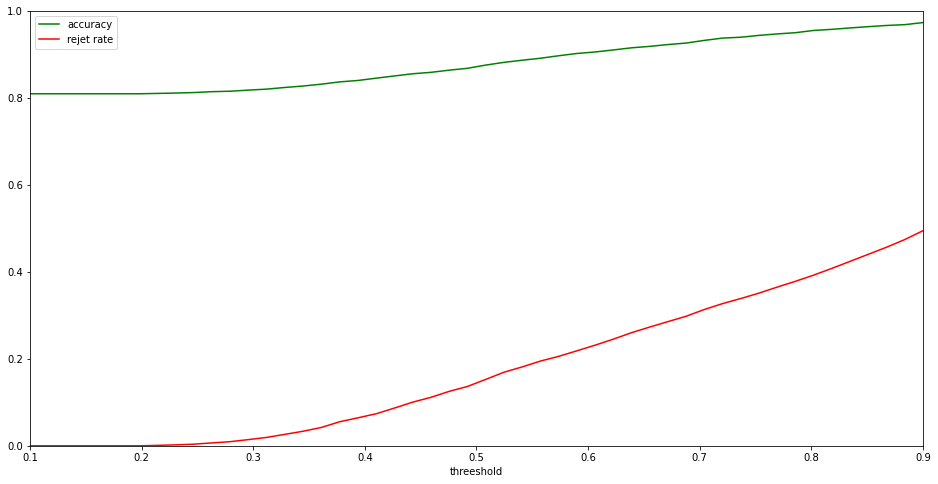

In [37]:
s = np.linspace(0.1,0.9,50)
h=plt.plot(s,acc,'-g',label='accuracy')
h=plt.plot(s,rej,'-r',label='rejet rate')
h=plt.xlabel("threeshold")
h=plt.legend()
h=plt.ylim(0,1)
h=plt.xlim(0.1,0.9)

In [35]:
s[acc>0.9][0]

0.589795918367347

In [36]:
rej[acc>0.9][0]

0.21826118588577664